# **1 - Importando o dataset diretamente do Kaggle**

O estudo foi feito com uma base de dados de compras existente, mas temos como objetivo tornar este padrão em uma API conectada a plataforma para recebimento de dados diretamente das compras feitas, gerando resultados visíveis para a empresa fornecedora.

Realização de previsões de reviews da Amazon por meio de técnicas de aprendizado de máquina, análise exploratória de dados utilizando as bibliotecas Matplotlib e Seaborn e algoritmos de pré-processamento são empregados para limpeza e preparação dos dados.

O modelo ainda está em fase de densevolvimento, testando a acurácia e entendimento das análises de sentimento através de avaliações feitas em compras e serviços. Futuramentge iremos trabalhar na integracáo do modelo via API, gerando análises diretas na nossa plataforma.

---



* 2TDSPS
* 96409 - Leonardo Guimarães de Lima Marques
* 97385 - José Carlos da Silva
* 97569 - Maria Luiza de Goveia Lima  
* 96906 - Mariana Marques Sabio
* 96881 - Vinícius de Abreu Pena




In [9]:
#Biaxando, descompactando e importando os arquivos usados no modelo, com tratamento de erro.

import os
import sys
import tarfile
import shutil
from tempfile import NamedTemporaryFile
from zipfile import ZipFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'amazon-reviews:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1340369%2F2233682%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240407%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240407T161559Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D985f01f09fde09a2929db259de47030a1d2f9d4380979fc5f2160d8c9af60e7c51749f1d5940470f96b2318536998aaf38ae02c01933eb30fc99cadd620df45a7fe715471791638613b3b1d06ff1ec39be343c2d40e847a5f823b131b6d3ab582d32534e11efd66f23508569ea9b6e1236c09b157d5d407e0e567d35cc7102c84b0d78ca1445280ea88f9849e82c8f392a05c0194e135be86c788e639126065da1b6f6d3d68a8c2f3ab2f85aa6724e848df3b0e2b5dfe755f5c609ff88eee5cb572d300962f57b1593ad218fd7a280a329a808b6c3172ca57ecf954a28e3784b0c2c297b5c12d86f66172616bf00ca987ad1a5f0f6a87dbf18f8da6d32ca8d2b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Falha ao carregar (expirou) {download_url} para o path {destination_path}')
        continue
    except OSError as e:
        print(f'Não foi possível fazer o donwload {download_url} para o path {destination_path}')
        continue

print('Importação de fonte de dados concluída')

[==================================================] 1389222210 bytes downloaded
Downloaded and uncompressed: amazon-reviews
Importação de fonte de dados concluída


# Importando bibliotecas e exibindo base de dados conectada antgeriormente.

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import warnings
import collections
import nltk
import os
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
warnings.filterwarnings("ignore")
nltk.download('punkt')
nltk.download('stopwords')
plt.style.use('dark_background')



for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/kaggle/input/amazon-reviews/amazon_review_polarity_csv.tgz
/kaggle/input/amazon-reviews/train.csv
/kaggle/input/amazon-reviews/test.csv


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
data=pd.read_csv("/kaggle/input/amazon-reviews/train.csv")
test=pd.read_csv("/kaggle/input/amazon-reviews/test.csv")

In [12]:
data.head()
test.head()

,2,Great CD,"My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I'm in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life's hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing ""Who was that singing ?"""
0,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
1,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
2,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
3,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...
4,1,DVD Player crapped out after one year,I also began having the incorrect disc problem...


# Processamento e limpeza dos dados.



In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3599999 entries, 0 to 3599998
Data columns (total 3 columns):
 #   Column                                                                                                                                                                                                                                                                                                                                                                                                      Dtype 
---  ------                                                                                                                                                                                                                                                                                                                                                                                                      ----- 
 0   2                                                                  

In [14]:
data.describe()

,2
count,3599999.0
mean,1.5
std,0.5
min,1.0
25%,1.0
50%,1.0
75%,2.0
max,2.0


In [15]:
data.shape

(3599999, 3)

In [16]:
data.columns=["Label","title","Text"]
test.columns=['Label',"title","Text"]
data.head()

,Label,title,Text
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
1,2,Amazing!,This soundtrack is my favorite music of all ti...
2,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
3,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
4,2,an absolute masterpiece,I am quite sure any of you actually taking the...


In [17]:
data = data.head(100000)
test = test.head(10000)

In [18]:
def concat_columns(df, col1, col2, new_col):
    df[new_col] = df[col1].apply(str) + ' ' + df[col2].apply(str)
    df.drop(col2, axis = 1, inplace = True)
    return df

data = concat_columns(data, 'Text', 'title', 'Text')
test = concat_columns(test, 'Text', 'title', 'Text')
data

,Label,Text
0,2,I'm reading a lot of reviews saying that this ...
1,2,This soundtrack is my favorite music of all ti...
2,2,I truly like this soundtrack and I enjoy video...
3,2,"If you've played the game, you know how divine..."
4,2,I am quite sure any of you actually taking the...
...,...,...
99995,1,THESE ARE THE REAL ADVENTURES OF THE REAL SUPE...
99996,1,Sylvain Beauregard is WIDELY known to die-hard...
99997,1,I think I now know more about the person who w...
99998,1,"This is what you call ""overkill."" How many boo..."


In [23]:
def clean_text(text):

    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('[^a-zA-Z0-9\s]+', '', text)
    text = re.sub('\w*\d\w*', '', text)
    stop_words = set(stopwords.words('english'))
    words = text.split()

    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)
    text = re.sub('\s+', ' ', text).strip()

    return text


In [24]:
  data


,Label,Text
0,2,I'm reading a lot of reviews saying that this ...
1,2,This soundtrack is my favorite music of all ti...
2,2,I truly like this soundtrack and I enjoy video...
3,2,"If you've played the game, you know how divine..."
4,2,I am quite sure any of you actually taking the...
...,...,...
99995,1,THESE ARE THE REAL ADVENTURES OF THE REAL SUPE...
99996,1,Sylvain Beauregard is WIDELY known to die-hard...
99997,1,I think I now know more about the person who w...
99998,1,"This is what you call ""overkill."" How many boo..."


In [25]:
stemmer = SnowballStemmer('english')

def stem_text(text):
    tokens = nltk.word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    return ' '.join(stemmed_tokens)

data['Text'] = data['Text'].apply(stem_text)
test["Text"]=test["Text"].apply(stem_text)

data.head()

,Label,Text
0,2,i 'm read a lot of review say that this is the...
1,2,this soundtrack is my favorit music of all tim...
2,2,i truli like this soundtrack and i enjoy video...
3,2,"if you ve play the game , you know how divin t..."
4,2,i am quit sure ani of you actual take the time...


# Gerando um wordcloud com palavras mais freqeuntes em comentarios positivios e negativos

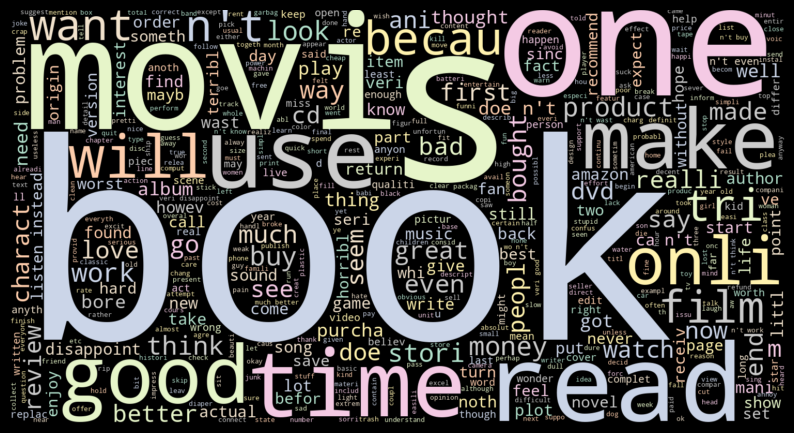

In [27]:
#Frases positivas serão 0
def wordcloud_text(text):

    plt.figure(figsize = (10, 8))
    wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'Pastel2_r').generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

positive_text = " ".join(data[data['Label'] == 1]['Text'])
wordcloud_text(positive_text)

Text(0, 0.5, 'Frequencia')

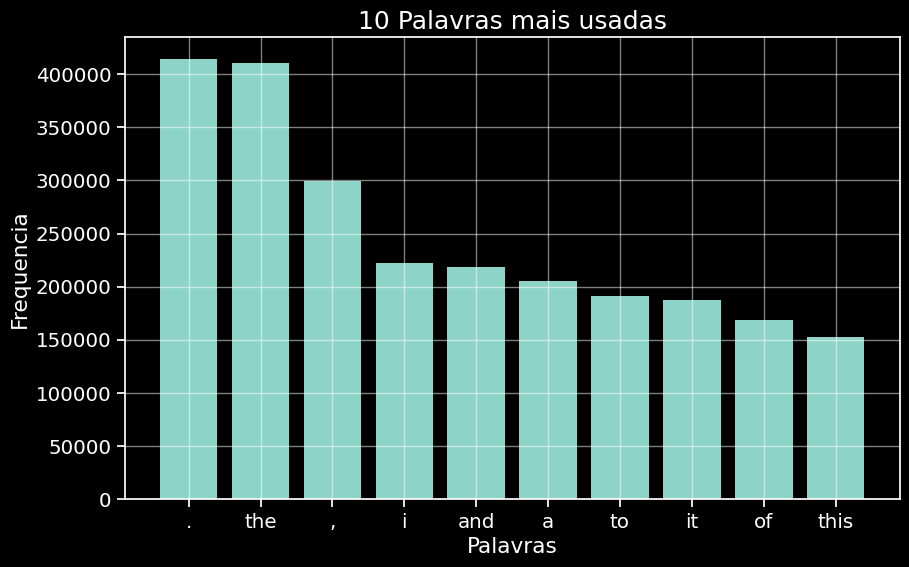

In [49]:
words = []
for text in data['Text']:
    words.extend(text.split())
word_count = collections.Counter(words)
top_words = dict(word_count.most_common(10))

# Figure Size
plt.figure(figsize = (10, 6))

# Create the Barplot
plt.bar(range(len(top_words)), list(top_words.values()), align = 'center')

# Creating a y axis with words
plt.xticks(range(len(top_words)), list(top_words.keys()))

# Grid Opacity
plt.grid(alpha = 0.5)

# Title and labels
plt.title('10 Palavras mais usadas em treino', fontsize = 18)
plt.xlabel('Palavras')
plt.ylabel('Frequencia')

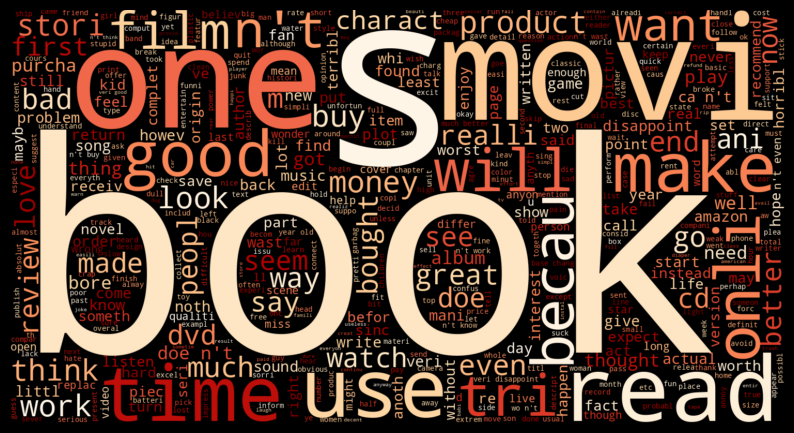

In [45]:
#Frases negativas serão 1
def wordcloud_text(text):

    plt.figure(figsize = (10, 8))
    wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'OrRd').generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

negative_text = " ".join(data[data['Label'] == 1]['Text'])
wordcloud_text(negative_text)

Text(0, 0.5, 'Frequencia')

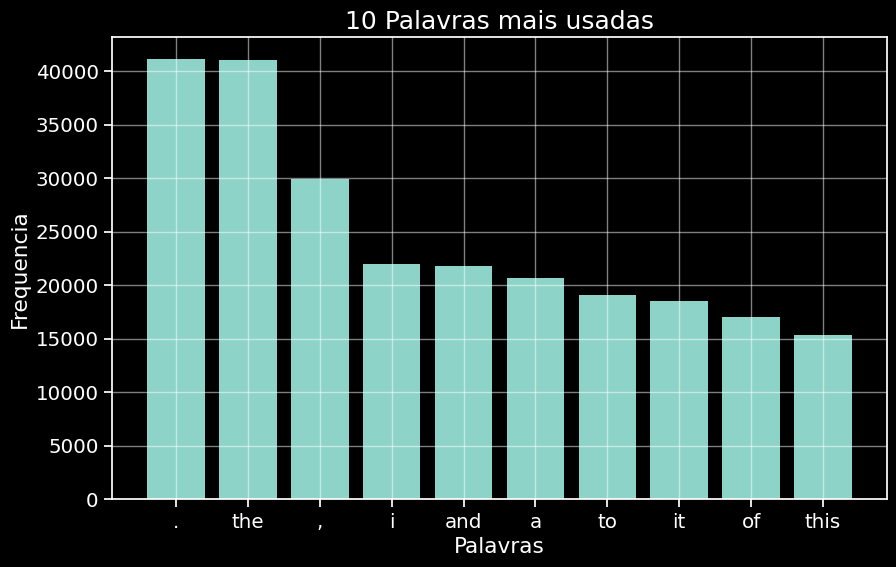

In [50]:
words = []
for text in test['Text']:
    words.extend(text.split())
word_count = collections.Counter(words)
top_words = dict(word_count.most_common(10))

# Figure Size
plt.figure(figsize = (10, 6))

# Create the Barplot
plt.bar(range(len(top_words)), list(top_words.values()), align = 'center')

# Creating a y axis with words
plt.xticks(range(len(top_words)), list(top_words.keys()))

# Grid Opacity
plt.grid(alpha = 0.5)
# Title and labels
plt.title('10 Palavras mais usadas em teste', fontsize = 18)
plt.xlabel('Palavras')
plt.ylabel('Frequencia')

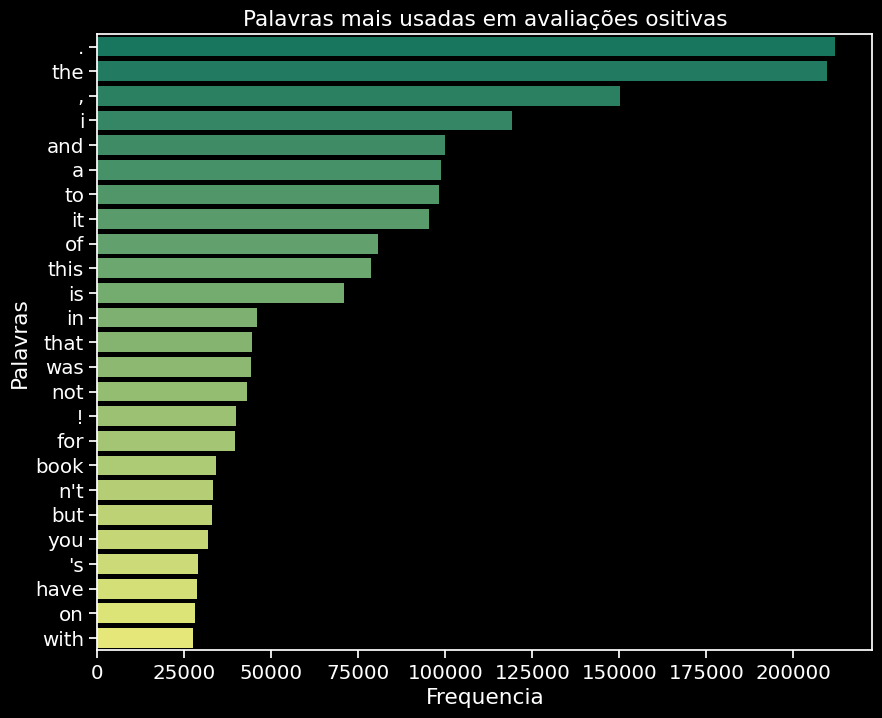

In [30]:
def plot_words_freq(words):

    df1 = pd.DataFrame(Counter(words).most_common(25), columns= ['Palavras', 'Frequencia'])

    sns.set_context('notebook', font_scale= 1.3)
    plt.figure(figsize=(10,8))
    sns.barplot(y = df1['Palavras'], x= df1['Frequencia'], palette= 'summer')
    plt.title("Palavras mais usadas em avaliações positivas")
    plt.xlabel("Frequencia")
    plt.ylabel("Palavras")
    return plt.show()


plot_words_freq((positive_text).split())

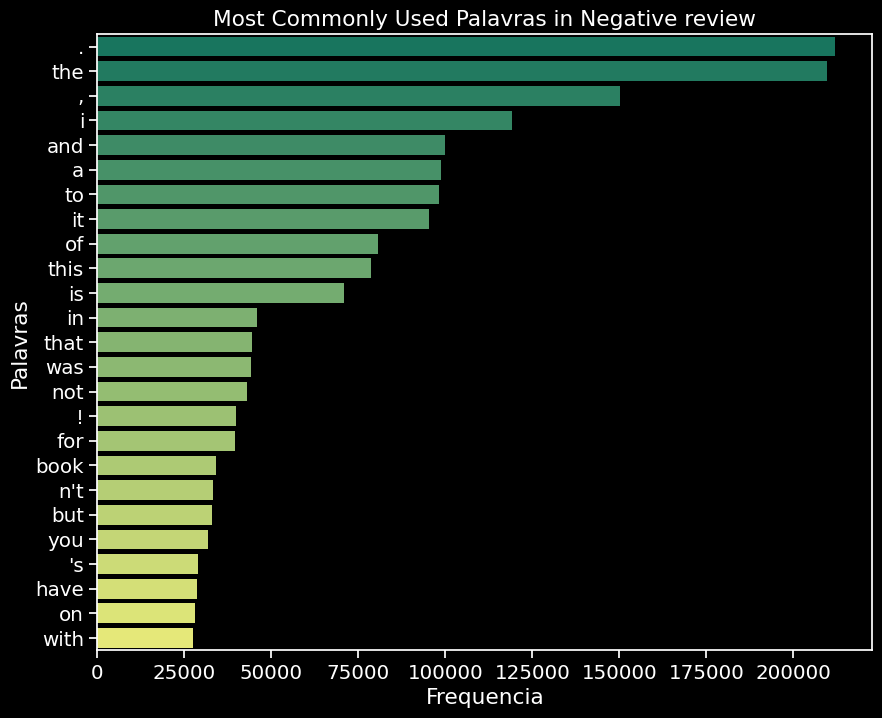

In [31]:
def plot_words_freq(words):

    df1 = pd.DataFrame(Counter(words).most_common(25), columns= ['Palavras', 'Frequencia'])

    sns.set_context('notebook', font_scale= 1.3)
    plt.figure(figsize=(10,8))
    sns.barplot(y = df1['Palavras'], x= df1['Frequencia'], palette= 'summer')
    plt.title("Most Commonly Used Palavras in Negative review")
    plt.xlabel("Frequencia")
    plt.ylabel("Palavras")
    return plt.show()


plot_words_freq((negative_text).split())


# Treinando o modelo

In [32]:
max_words = 10000
max_len = 200
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(data['Text'])
sequences_train = tokenizer.texts_to_sequences(data['Text'])
sequences_val = tokenizer.texts_to_sequences(data['Text'])
word_index = tokenizer.word_index

In [33]:
data_train = pad_sequences(sequences_train, maxlen = max_len)
data_val = pad_sequences(sequences_val, maxlen = max_len)

In [34]:
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(data['Text'])
y = data['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
nb_model = MultinomialNB().fit(X_train, y_train)
nb_model.score(X_test,y_test)

0.84575

# Tensorflow

In [36]:

model = tf.keras.Sequential()
model.add(Embedding(max_words, 16, input_length = max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))


model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 16)           160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 10)                170       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 160181 (625.71 KB)
Trainable params: 160181 (625.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
history = model.fit(data_train, data['Label'], epochs = 10, batch_size = 64, validation_data = (data_val,data['Label']))

Epoch 1/10
1563/1563 [==============================] - 16s 10ms/step - loss: -201.3738 - accuracy: 0.4873 - val_loss: -772.9210 - val_accuracy: 0.4873
Epoch 2/10
1563/1563 [==============================] - 12s 8ms/step - loss: -2447.0366 - accuracy: 0.4873 - val_loss: -4784.3574 - val_accuracy: 0.4873
Epoch 3/10
1563/1563 [==============================] - 14s 9ms/step - loss: -8528.5303 - accuracy: 0.4873 - val_loss: -13067.7197 - val_accuracy: 0.4873
Epoch 4/10
1563/1563 [==============================] - 15s 9ms/step - loss: -19292.5820 - accuracy: 0.4873 - val_loss: -26414.4043 - val_accuracy: 0.4873
Epoch 5/10
1563/1563 [==============================] - 13s 8ms/step - loss: -35417.0781 - accuracy: 0.4873 - val_loss: -45463.6133 - val_accuracy: 0.4873
Epoch 6/10
1563/1563 [==============================] - 13s 8ms/step - loss: -57679.4336 - accuracy: 0.4873 - val_loss: -71040.8281 - val_accuracy: 0.4873
Epoch 7/10
1563/1563 [==============================] - 15s 10ms/step - loss

In [38]:
loss, accuracy = model.evaluate(data_val, data['Label'], verbose = 0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 48.732999


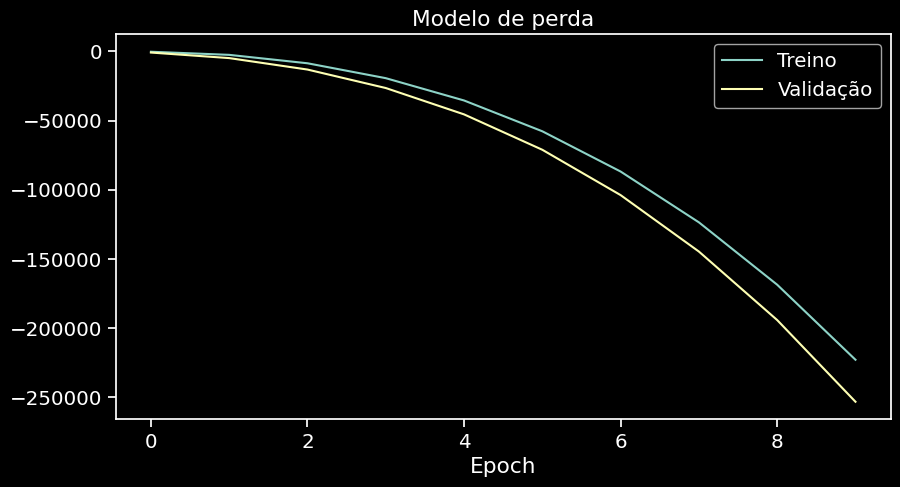

In [55]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Modelo de perda')
plt.xlabel('Epoch')
plt.legend(['Treino', 'Validação'], loc = 'upper right')
plt.show()